# Leandro Biasi Ferlin

Objetivo: apresentar um modelo de predição para o valor de vendas ('sold_quantity')

In [26]:
import pandas as pd 
import numpy as np 
from collections import OrderedDict 
from functools import reduce 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.image as pltimg
from datetime import datetime 
#from fbprophet import Prophet 
from pylab import rcParams 
#from klearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 
from sklearn import linear_model
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error 
import statsmodels.api as sm
import pydotplus
from graphviz import Source
import json
from pandas.io.json import json_normalize
import urllib
import gzip
import plotly.express as px
from geopy.geocoders import Nominatim


Para esse case, é utilizada a base de busca por TV's 4k no site da Argentina. A API retorna os dados em formato JSON, que é convertido para formato tabular com os dados do campo 'results'.

In [27]:
#carrega dados com base na busca pela api
url_work = "https://api.mercadolibre.com/sites/MLA/search?q=tv%204k"
response_work = urllib.request.urlopen(url_work)
data_work = response_work.read()
values_work = json.loads(data_work)
#normaliza e converte JSON para DataFrame
df_work=json_normalize(values_work['results'])
df_work.head()

,accepts_mercadopago,address.city_id,address.city_name,address.state_id,address.state_name,attributes,available_quantity,buying_mode,catalog_listing,catalog_product_id,...,shipping.store_pick_up,shipping.tags,site_id,sold_quantity,stop_time,tags,thumbnail,thumbnail_id,title,use_thumbnail_id
0,True,None,Núñez,AR-C,Capital Federal,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",9,buy_it_now,True,MLA16233171,...,False,"[fulfillment, self_service_out, mandatory_free...",MLA,324,2041-07-11T20:06:43.000Z,"[ahora-12, brand_verified, extended_warranty_e...",http://http2.mlstatic.com/D_878604-MLA44160072...,878604-MLA44160072739_112020,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,True
1,True,None,Monte Chingolo,AR-B,Buenos Aires,"[{'name': 'Marca', 'value_name': 'Noblex', 'va...",1,buy_it_now,NaN,None,...,False,"[fulfillment, mandatory_free_shipping]",MLA,250,2041-05-16T04:00:00.000Z,"[loyalty_discount_eligible, ahora-12, catalog_...",http://http2.mlstatic.com/D_890948-MLA46348285...,890948-MLA46348285357_062021,Smart Tv Noblex Dk55x6500 Led 4k 55,True
2,True,TUxBQ0JBSDI0OTNk,Bahía Blanca,AR-B,Buenos Aires,"[{'value_struct': None, 'attribute_group_name'...",23,buy_it_now,True,MLA14141341,...,False,"[fulfillment, self_service_out, mandatory_free...",MLA,184,2041-03-14T04:00:00.000Z,"[good_quality_thumbnail, loyalty_discount_elig...",http://http2.mlstatic.com/D_700522-MLA46539887...,700522-MLA46539887496_062021,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,True
3,True,None,Villa Celina,AR-B,Buenos Aires,"[{'attribute_group_id': 'MAIN', 'name': 'Marca...",500,buy_it_now,NaN,MLA16233171,...,False,"[fulfillment, mandatory_free_shipping]",MLA,500,2040-12-16T15:13:35.000Z,"[ahora-12, brand_verified, extended_warranty_e...",http://http2.mlstatic.com/D_787429-MLA43816255...,787429-MLA43816255167_102020,Smart Tv Samsung 50 4k Uhd 50tu7000,True
4,True,None,Villa Celina,AR-B,Buenos Aires,"[{'value_name': 'BGH', 'values': [{'struct': N...",150,buy_it_now,NaN,None,...,False,"[fulfillment, mandatory_free_shipping]",MLA,150,2041-07-11T11:58:06.000Z,"[catalog_product_candidate, extended_warranty_...",http://http2.mlstatic.com/D_893006-MLA46430431...,893006-MLA46430431526_062021,Smart Tv Bgh 50 Uhd Android,True


Para auxiliar na análise foram criadas colunas de valores relativos. São elas: 
*hasDiscount : valor que indica se há ou não desconto no produto. 
*vDiscount : valor absoluto do desconto. Quando não há desconto o valor é zero. 
*perc_vDiscount : valor percentual do desconto em relação ao preço original.

In [16]:
#padroniza dados nulos para formato correto
df_work=  df_work.where(pd.notnull(df_work),None)

#cria coluna t/f que sinaliza se há desconto
df_work['hasDiscount']=np.where(df_work['original_price'].isnull(),0,1)

#cria coluna com valor absoluto de desconto
df_work['vDiscount']=(np.where(df_work['original_price'].isnull(),0,(df_work['original_price']-df_work['price']))).astype(float)

#cria coluna com valor percentual de desconto
df_work['perc_vDiscount']=(df_work['vDiscount']/df_work['original_price']).astype(float)



Para entender o perfil da base de dados, inicia-se pela tabela de correlação. São utilizadas as variáveis quantitativas, cujo conjunto abrange a variável alvo 'sold_quantity'. É possível notar algumas fortes correlações entre variáveis independentes, que devem ser levadas em conta para o modelo futuro. No caso da variável alvo, as maiores correações estão relacionadas à quantidade de items disponíveis e à reputação do vendedor.

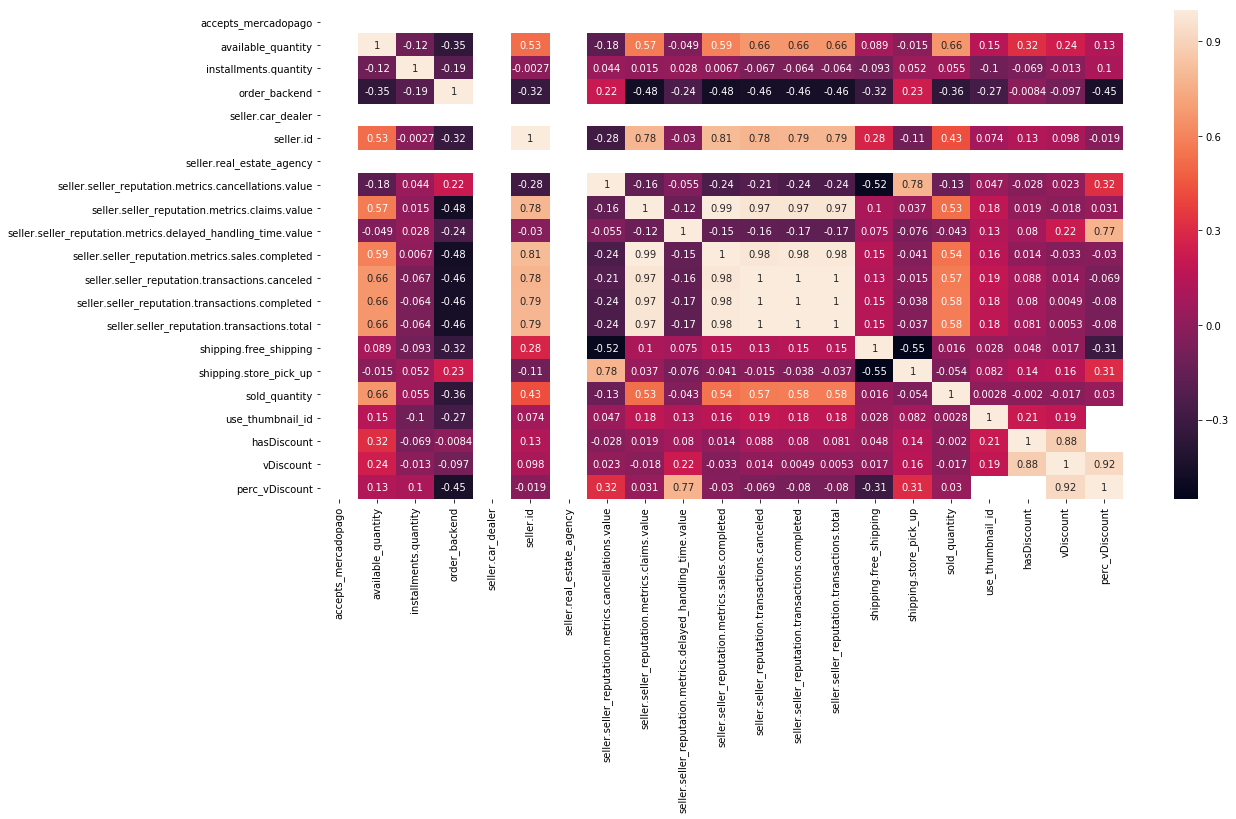

In [5]:
#gera e plota a base de correlação entre variáveis
basecorr=df_work.corr()
plt.figure(figsize = (18,9))
sns.heatmap(basecorr, annot=True)


Numa tentativa de enteder se alguma variável qualitativa pode interferir no modelo, se fez um teste transformando uma variável qualit. em colunas dummies. No caso, foi utilizado o campo de Estado. Percebe-se, por exemplo, que o Estado de Buenos Aires tem algumas correlações maiores com questões de desconto e avaliações de reputação, o que indica em primeira análise que a maioria da aplicação destes campos se concentram nessa localidade. 

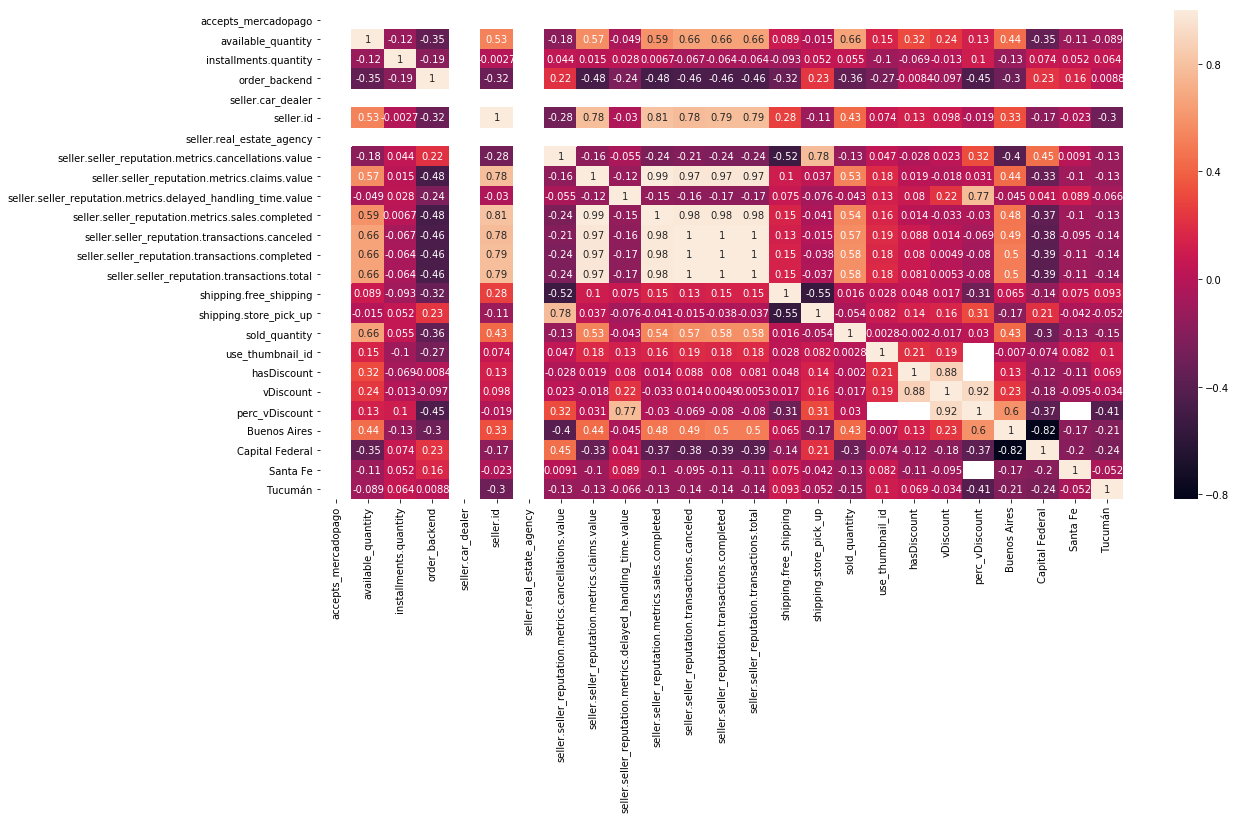

In [6]:
#transforma valores campo qualitativo de Estado em colunas dummies
base_dummies = pd.get_dummies(df_work['address.state_name'])

#gera nova base de trabalho
df_work_new = pd.concat([df_work, base_dummies], axis=1)

#novo mapa de correlação com as variáveis dummies
basecorr_new=df_work_new.corr()
plt.figure(figsize = (18,9))
sns.heatmap(basecorr_new, annot=True)

Para facilitar a visualização e iniciar o processo do modelo, se isolou apenas os valores de correlação com a variável alvo 'sold_quantity'

In [8]:
#mostra as correlações com a variável 'sold_quantity'
basecorr2=df_work_new[df_work_new.columns[1:]].corr()['sold_quantity'][:-1]
print(basecorr2.reindex(basecorr2.abs().sort_values(ascending=False).index))
   

sold_quantity                                                   1.000000
available_quantity                                              0.661092
seller.seller_reputation.transactions.completed                 0.578942
seller.seller_reputation.transactions.total                     0.578675
seller.seller_reputation.transactions.canceled                  0.572482
seller.seller_reputation.metrics.sales.completed                0.543680
seller.seller_reputation.metrics.claims.value                   0.530938
seller.id                                                       0.429039
Buenos Aires                                                    0.428102
order_backend                                                  -0.362119
Capital Federal                                                -0.303834
seller.seller_reputation.metrics.cancellations.value           -0.127086
Santa Fe                                                       -0.125815
installments.quantity                              

O método escolhido inicialmente para o modelo foi o Método dos Mínimos Quadrados (Regressão Linear Multi). A ideia é encontrar variáveis que levem o mais próximo da linearidade que explique a relação de 'sold_quantity'. Para a seleção de variáveis foi usado a técnica Stepwise em diferentes testes.  

In [24]:
#substitui nulos por zero para corrigir erro da função
df_work_model=df_work_model.fillna(0)

#seta a variável alvo (y) e cria a base de variaveis independentes (X)
X = df_work_model[['available_quantity'
                    ,'seller.seller_reputation.transactions.total'
                    ,'vDiscount'
                   #,'seller.seller_reputation.transactions.completed'
                   #,'order_backend'
                   #,'Buenos Aires'
                   #,'perc_vDiscount'
                   #,'hasDiscount'
                  ]]


y = df_work_model['sold_quantity']



Para a criação e validação do modelo foram geradas duas bases: uma de treino e outra de teste. Por conta do tamanho reduzido da base geral, as bases foram separadas em 80%treino/20%teste. Os dados mostram que as variáveis selecionadas possuem p-valor<0.05, reforçando a 'força' das variáveis. 
Observado o R2-Ajustado, o modelo não se mostra 'forte', pois explica ~68% da variância de y.Porém adequado pela quantidade de dados e explicativo pelas relações.


                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     25.46
Date:                Tue, 20 Jul 2021   Prob (F-statistic):           4.15e-09
Time:                        06:18:04   Log-Likelihood:                -285.50
No. Observations:                  40   AIC:                             577.0
Df Residuals:                      37   BIC:                             582.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

C:\Users\lbferlin\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


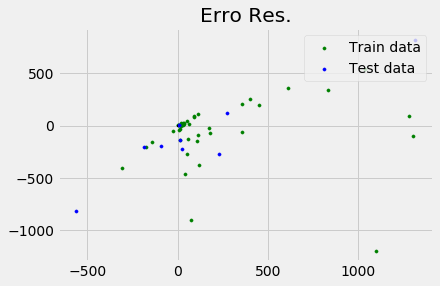

In [25]:
# gera bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1)

#roda modelo Ordinary Least Squares - Regressao Linear   
Xline = sm.add_constant(X_train.astype(float))
model = sm.OLS(y_train.astype(float), X_train.astype(float))
modelfit = model.fit()
print(modelfit.summary())

  
#plota erros residuais de teste e treino
plt.style.use('fivethirtyeight')

plt.scatter(modelfit.predict(X_train), modelfit.predict(X_train) - y_train,
            color = "green", s = 10, label = 'Train data')

plt.scatter(modelfit.predict(X_test), modelfit.predict(X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')

#definições de grafico  
plt.hlines(y = 0, xmin = -1, xmax = 1, linewidth = 2)
plt.legend(loc = 'upper right')
plt.title("Erro Res.")
plt.show()

#### Conclusões e considerações

1-A variável 'available_quantity' apresenta o menor p-valor e um coeficiente relativamente alto. O que quer dizer que essa variável tem forte influência nas previsões. Pela característica apresentada, quanto mais quantidade disponível mais é vendido. Em termos práticos, porém, há de se atentar que não é assim que funciona. Variável poderia ser revista (como foi o 'seller_id).

2-O valor de desconto vDiscount está relacionado à um valor de coeficiente negativo. Isso quer dizer que quanto maior o desconto, menor a quantidade de venda. Isso na prática não faz muito sentido, e pode indicar que existe um ponto de equilibrio para a aplicação de descontos. Para corrigir podemos retirar a variável 'available_quantity', em contrapartida o R2 cai drásticamente.

3-Percebe-se o erro residual disperso, apesar de ter boa concetração próximo a 0. Fator para entender a acurácia.

4-Como negócio, vale a pena entender fatores temporais para contribuir com modelo. Além disso, vale a tratativa por clusters para entender se há algum comportamento por nicho.
Outros metodos podem ser testados, como uma árvore de decisão que indica se o 'sold_quantity' fica ou não entre um range de valores. Ou então, uma rede neural, com as resalvas para tamanho de base e complexidade.

5-Fatores externos, implicitos ao negócio e fora do controle da empresa também devem ser levados em conta.

6-Maiores explicações de negócio no .ppt no repositório.



In [21]:
#Outro metodo de LM

reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)
print('Variables:   ',list(X_train))  
print('Coefficients: ', reg.coef_)
print('Variance score: {}'.format(reg.score(X_train, y_train)))
#print(reg.score)

Variables:    ['available_quantity', 'seller.seller_reputation.transactions.total', 'vDiscount']
Coefficients:  [ 1.93078841e+00  4.23837870e-04 -3.19245933e-02]
Variance score: 0.581883426538083
